In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"
!unzip -q dataset.zip

In [ ]:
!unzip -q dataset/dualclass.zip
!unzip -q dataset/test2classes.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('dualclass/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)



['NORM' 'TUM']


In [ ]:
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)

test_files=files
test_classes = classes
print(len(test_files))
print(len(train_files))
print(len(val_files))

7200
21221
9096


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_val = 10 #
batch_size_test = 100 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('dualclass/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('dualclass/', val_files, val_classes, 
                        transforms=image_transform)
test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size_val, 
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


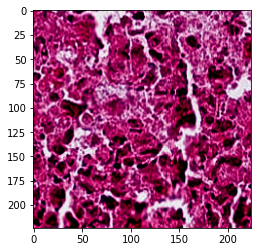

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(val_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class SeparableConv(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnection = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnection = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnection:
            skip = self.skipConnection(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        #self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.conv3 = SeparableConv(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        #x = self.block5(x)
        #x = self.block6(x)
        #x = self.block7(x)
        #x = self.block8(x)
        #x = self.block9(x)
        #x = self.block10(x)
        #x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def validation(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    y=[]
    y_pred=[]
    prob=[]
    for data, target in test_loader:
        t=target.tolist()
        y.append(t)
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        p=output.tolist()
        prob.append(p)     
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        m=pred.tolist()
        y_pred.append(m) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg, y,y_pred,prob

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

Drive not mounted, so nothing to flush and unmount.


In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

accuracy=[]
for t in range(5):
  print ("Experiment: ", t+1)
  num_epoch = 30

  acc=0
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=2).to(device)
  learning_rate = 0.001
  weight_decay = 0.001
  for param in model.parameters():
      param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)
  for epoch in range(1, num_epoch + 1):
      print(epoch)
      tl=train(model, device, train_loader, optimizer)
      stl,acct=validation(model, device, val_loader)
      if acc<acct:
        if path.exists("Xception2categoriesmodel.pth"):
          os.remove("Xception2categoriesmodel.pth")

        torch.save(model.state_dict(), 'Xception2categoriesmodel.pth')
        acc=acct
   

#!cp Xception2categoriesmodel.pth '/content/drive/My Drive/Histopathology data/'
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=2)
  model.load_state_dict(torch.load('Xception2categoriesmodel.pth', map_location=device))
  model=model.to(device)

  stl,acct,y,y_pred,prob=test(model, device, test_loader)
  accuracy.append(acct)


print(accuracy)


Experiment:  1
1


<ipython-input-11-11d4e74c9e3a>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3562

Test: Average loss: 0.1509, Accuracy: 8566/9096 (94.17%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2290

Test: Average loss: 0.1400, Accuracy: 8616/9096 (94.72%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1598

Test: Average loss: 0.1300, Accuracy: 8678/9096 (95.40%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1218

Test: Average loss: 0.0985, Accuracy: 8758/9096 (96.28%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1017

Test: Average loss: 0.0679, Accuracy: 8872/9096 (97.54%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0795

Test: Average loss: 0.1266, Accuracy: 8648/9096 (95.07%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0709

Test: Average loss: 0.0621, Accuracy: 8907/9096 (97.92%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0677

Test: Average loss: 0.1522, Accuracy: 8634/9096 (94.92%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0648

Test: Average loss: 0.0500, Accuracy: 8960/9096 (98.50%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0524

Test: Average loss: 0.0415, Accuracy: 8973/9096 (98.65%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0507

Test: Average loss: 0.0505, Accuracy: 8948/9096 (98.37%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0420

Test: Average loss: 0.0421, Accuracy: 8954/9096 (98.44%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0380

Test: Average loss: 0.0392, Accuracy: 8990/9096 (98.83%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0359

Test: Average loss: 0.0431, Accuracy: 8966/9096 (98.57%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0415

Test: Average loss: 0.0409, Accuracy: 8974/9096 (98.66%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0280

Test: Average loss: 0.0340, Accuracy: 8995/9096 (98.89%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0326

Test: Average loss: 0.0430, Accuracy: 8952/9096 (98.42%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0234

Test: Average loss: 0.0465, Accuracy: 8960/9096 (98.50%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0249

Test: Average loss: 0.0446, Accuracy: 8949/9096 (98.38%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0278

Test: Average loss: 0.0403, Accuracy: 8973/9096 (98.65%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0220

Test: Average loss: 0.0694, Accuracy: 8872/9096 (97.54%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0181

Test: Average loss: 0.0389, Accuracy: 8978/9096 (98.70%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0131

Test: Average loss: 0.0447, Accuracy: 8970/9096 (98.61%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0167

Test: Average loss: 0.0363, Accuracy: 8995/9096 (98.89%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0138

Test: Average loss: 0.0399, Accuracy: 8993/9096 (98.87%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0163

Test: Average loss: 0.0931, Accuracy: 8845/9096 (97.24%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0160

Test: Average loss: 0.0693, Accuracy: 8935/9096 (98.23%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0128

Test: Average loss: 0.0405, Accuracy: 8991/9096 (98.85%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0132

Test: Average loss: 0.0445, Accuracy: 8984/9096 (98.77%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0097

Test: Average loss: 0.0501, Accuracy: 8950/9096 (98.39%)

Test: Average loss: 0.0198, Accuracy: 7157/7200 (99.40%)

Experiment:  2
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3690

Test: Average loss: 0.1470, Accuracy: 8629/9096 (94.87%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2207

Test: Average loss: 0.0919, Accuracy: 8817/9096 (96.93%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1605

Test: Average loss: 0.0743, Accuracy: 8855/9096 (97.35%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1293

Test: Average loss: 0.1810, Accuracy: 8526/9096 (93.73%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0998

Test: Average loss: 0.1615, Accuracy: 8606/9096 (94.61%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0894

Test: Average loss: 0.0604, Accuracy: 8922/9096 (98.09%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0798

Test: Average loss: 0.0530, Accuracy: 8940/9096 (98.28%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0711

Test: Average loss: 0.0912, Accuracy: 8800/9096 (96.75%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0669

Test: Average loss: 0.0676, Accuracy: 8867/9096 (97.48%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0552

Test: Average loss: 0.0751, Accuracy: 8862/9096 (97.43%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0480

Test: Average loss: 0.0693, Accuracy: 8895/9096 (97.79%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0566

Test: Average loss: 0.0453, Accuracy: 8949/9096 (98.38%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0416

Test: Average loss: 0.0346, Accuracy: 8981/9096 (98.74%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0399

Test: Average loss: 0.0449, Accuracy: 8966/9096 (98.57%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0347

Test: Average loss: 0.0407, Accuracy: 8972/9096 (98.64%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0327

Test: Average loss: 0.0356, Accuracy: 8974/9096 (98.66%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0299

Test: Average loss: 0.0542, Accuracy: 8918/9096 (98.04%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0244

Test: Average loss: 0.0397, Accuracy: 8977/9096 (98.69%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0243

Test: Average loss: 0.0713, Accuracy: 8891/9096 (97.75%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0230

Test: Average loss: 0.0566, Accuracy: 8934/9096 (98.22%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0180

Test: Average loss: 0.0553, Accuracy: 8937/9096 (98.25%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0165

Test: Average loss: 0.0395, Accuracy: 8979/9096 (98.71%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0193

Test: Average loss: 0.0539, Accuracy: 8933/9096 (98.21%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0217

Test: Average loss: 0.0382, Accuracy: 8991/9096 (98.85%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0182

Test: Average loss: 0.0349, Accuracy: 8975/9096 (98.67%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0143

Test: Average loss: 0.0450, Accuracy: 8967/9096 (98.58%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0096

Test: Average loss: 0.0429, Accuracy: 8956/9096 (98.46%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0145

Test: Average loss: 0.0431, Accuracy: 8982/9096 (98.75%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0085

Test: Average loss: 0.0425, Accuracy: 8984/9096 (98.77%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0141

Test: Average loss: 0.0414, Accuracy: 8984/9096 (98.77%)

Test: Average loss: 0.0186, Accuracy: 7159/7200 (99.43%)

Experiment:  3
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3677

Test: Average loss: 0.2322, Accuracy: 8249/9096 (90.69%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2337

Test: Average loss: 0.3768, Accuracy: 7391/9096 (81.26%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1682

Test: Average loss: 0.0713, Accuracy: 8870/9096 (97.52%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1316

Test: Average loss: 0.1047, Accuracy: 8744/9096 (96.13%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1025

Test: Average loss: 0.0719, Accuracy: 8883/9096 (97.66%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0869

Test: Average loss: 0.0628, Accuracy: 8907/9096 (97.92%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0829

Test: Average loss: 0.0646, Accuracy: 8903/9096 (97.88%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0741

Test: Average loss: 0.0612, Accuracy: 8913/9096 (97.99%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0676

Test: Average loss: 0.0542, Accuracy: 8937/9096 (98.25%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0561

Test: Average loss: 0.0465, Accuracy: 8955/9096 (98.45%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0509

Test: Average loss: 0.0477, Accuracy: 8951/9096 (98.41%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0452

Test: Average loss: 0.0839, Accuracy: 8830/9096 (97.08%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0412

Test: Average loss: 0.0386, Accuracy: 8982/9096 (98.75%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0323

Test: Average loss: 0.0646, Accuracy: 8911/9096 (97.97%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0313

Test: Average loss: 0.0406, Accuracy: 8969/9096 (98.60%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0269

Test: Average loss: 0.0598, Accuracy: 8880/9096 (97.63%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0256

Test: Average loss: 0.0771, Accuracy: 8838/9096 (97.16%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0232

Test: Average loss: 0.0470, Accuracy: 8967/9096 (98.58%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0214

Test: Average loss: 0.0604, Accuracy: 8908/9096 (97.93%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0166

Test: Average loss: 0.1225, Accuracy: 8684/9096 (95.47%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0197

Test: Average loss: 0.0417, Accuracy: 8979/9096 (98.71%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0168

Test: Average loss: 0.0417, Accuracy: 8971/9096 (98.63%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0136

Test: Average loss: 0.0457, Accuracy: 8973/9096 (98.65%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0171

Test: Average loss: 0.0510, Accuracy: 8961/9096 (98.52%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0131

Test: Average loss: 0.1552, Accuracy: 8613/9096 (94.69%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0079

Test: Average loss: 0.0471, Accuracy: 8968/9096 (98.59%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0074

Test: Average loss: 0.0412, Accuracy: 8979/9096 (98.71%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0097

Test: Average loss: 0.0464, Accuracy: 8972/9096 (98.64%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0111

Test: Average loss: 0.0470, Accuracy: 8973/9096 (98.65%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0083

Test: Average loss: 0.0409, Accuracy: 8980/9096 (98.72%)

Test: Average loss: 0.0236, Accuracy: 7151/7200 (99.32%)

Experiment:  4
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3763

Test: Average loss: 0.1777, Accuracy: 8468/9096 (93.10%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2271

Test: Average loss: 0.2673, Accuracy: 8293/9096 (91.17%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1644

Test: Average loss: 0.0818, Accuracy: 8835/9096 (97.13%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1217

Test: Average loss: 0.2017, Accuracy: 8506/9096 (93.51%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1009

Test: Average loss: 0.0930, Accuracy: 8807/9096 (96.82%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0842

Test: Average loss: 0.0658, Accuracy: 8882/9096 (97.65%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0729

Test: Average loss: 0.0795, Accuracy: 8845/9096 (97.24%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0697

Test: Average loss: 0.0890, Accuracy: 8829/9096 (97.06%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0607

Test: Average loss: 0.0450, Accuracy: 8945/9096 (98.34%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0520

Test: Average loss: 0.0579, Accuracy: 8921/9096 (98.08%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0533

Test: Average loss: 0.0536, Accuracy: 8913/9096 (97.99%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0431

Test: Average loss: 0.0441, Accuracy: 8963/9096 (98.54%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0389

Test: Average loss: 0.0509, Accuracy: 8945/9096 (98.34%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0372

Test: Average loss: 0.0459, Accuracy: 8966/9096 (98.57%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0306

Test: Average loss: 0.0410, Accuracy: 8979/9096 (98.71%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0284

Test: Average loss: 0.0598, Accuracy: 8926/9096 (98.13%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0251

Test: Average loss: 0.0588, Accuracy: 8915/9096 (98.01%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0249

Test: Average loss: 0.0399, Accuracy: 8980/9096 (98.72%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0281

Test: Average loss: 0.0647, Accuracy: 8914/9096 (98.00%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0248

Test: Average loss: 0.0398, Accuracy: 8988/9096 (98.81%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0232

Test: Average loss: 0.0356, Accuracy: 8989/9096 (98.82%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0264

Test: Average loss: 0.0529, Accuracy: 8939/9096 (98.27%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0116

Test: Average loss: 0.0411, Accuracy: 8978/9096 (98.70%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0121

Test: Average loss: 0.0583, Accuracy: 8950/9096 (98.39%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0129

Test: Average loss: 0.0582, Accuracy: 8946/9096 (98.35%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0119

Test: Average loss: 0.0517, Accuracy: 8953/9096 (98.43%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0114

Test: Average loss: 0.0599, Accuracy: 8927/9096 (98.14%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0226

Test: Average loss: 0.0685, Accuracy: 8904/9096 (97.89%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0131

Test: Average loss: 0.0438, Accuracy: 8976/9096 (98.68%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0111

Test: Average loss: 2.0433, Accuracy: 6975/9096 (76.68%)

Test: Average loss: 0.0210, Accuracy: 7156/7200 (99.39%)

Experiment:  5
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3788

Test: Average loss: 0.3045, Accuracy: 8058/9096 (88.59%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2311

Test: Average loss: 0.3069, Accuracy: 7983/9096 (87.76%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1622

Test: Average loss: 0.0811, Accuracy: 8855/9096 (97.35%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1259

Test: Average loss: 0.0831, Accuracy: 8823/9096 (97.00%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1036

Test: Average loss: 0.0659, Accuracy: 8901/9096 (97.86%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0953

Test: Average loss: 0.7496, Accuracy: 7728/9096 (84.96%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0774

Test: Average loss: 0.1542, Accuracy: 8503/9096 (93.48%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0647

Test: Average loss: 0.1067, Accuracy: 8816/9096 (96.92%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0623

Test: Average loss: 0.0530, Accuracy: 8950/9096 (98.39%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0550

Test: Average loss: 0.0425, Accuracy: 8966/9096 (98.57%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0432

Test: Average loss: 0.0480, Accuracy: 8957/9096 (98.47%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0405

Test: Average loss: 0.0885, Accuracy: 8803/9096 (96.78%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0490

Test: Average loss: 0.0350, Accuracy: 8999/9096 (98.93%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0331

Test: Average loss: 0.0604, Accuracy: 8934/9096 (98.22%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0301

Test: Average loss: 0.0405, Accuracy: 8971/9096 (98.63%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0243

Test: Average loss: 0.0452, Accuracy: 8985/9096 (98.78%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0244

Test: Average loss: 0.0472, Accuracy: 8953/9096 (98.43%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0185

Test: Average loss: 0.0566, Accuracy: 8943/9096 (98.32%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0176

Test: Average loss: 0.0451, Accuracy: 8971/9096 (98.63%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0164

Test: Average loss: 0.0401, Accuracy: 8992/9096 (98.86%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0163

Test: Average loss: 0.0454, Accuracy: 8988/9096 (98.81%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0120

Test: Average loss: 0.0525, Accuracy: 8954/9096 (98.44%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0192

Test: Average loss: 0.0373, Accuracy: 8978/9096 (98.70%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0102

Test: Average loss: 0.0449, Accuracy: 8966/9096 (98.57%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0073

Test: Average loss: 0.0396, Accuracy: 8994/9096 (98.88%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0124

Test: Average loss: 0.0438, Accuracy: 8968/9096 (98.59%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0069

Test: Average loss: 0.0774, Accuracy: 8869/9096 (97.50%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0111

Test: Average loss: 0.0460, Accuracy: 8974/9096 (98.66%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0094

Test: Average loss: 0.0390, Accuracy: 8990/9096 (98.83%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0066

Test: Average loss: 0.0419, Accuracy: 8990/9096 (98.83%)

Test: Average loss: 0.0236, Accuracy: 7149/7200 (99.29%)

[99.40277777777777, 99.43055555555556, 99.31944444444444, 99.38888888888889, 99.29166666666667]


In [1]:
import numpy as np
acc=np.array([99.40277777777777, 99.43055555555556, 99.31944444444444, 99.38888888888889, 99.29166666666667])
print(np.mean(acc))
print(np.std(acc))

99.36666666666666
0.05241100628920153


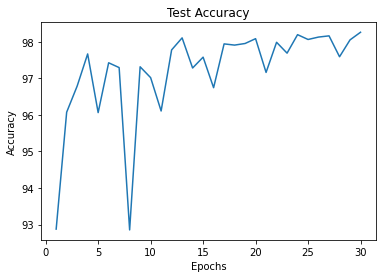

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()